In [1]:
author="Jumabek Alikhanov"
date = 'Nov 22,2019'

This is Final Project material for the "Deep Learning" class I took  

## Download the dataset from https://www.unb.ca/cic/datasets/ids-2017.html
We only need CSV files that is preprocessed and labeled for ML 

In [2]:
#imports
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
%load_ext autoreload

In [3]:
# load data
dataroot = 'MachineLearningCVE/'
SEED=2

In [4]:
%autoreload 2
from preprocessing import load_data
X,y = load_data(dataroot) # reads csv file and returns np array of X,y -> of shape (N,D) and (N,1)

MachineLearningCVE/*.pcap_ISCX.csv
there are 2830743 flow records with 79 feature dimension
stripped column names
dropped bad columns
There are 0 nan entries
converted to numeric


## Data Imbalance
1. It is curucial to adress this issue in order to get decent performance
2. It also affects evaluation, we should calculate  `balanced accuracy`

In [5]:
from preprocessing import balance_data, normalize
X = normalize(X)

In [6]:

%autoreload 2
from models import Classifier

def ensure_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def getClassifier(args,runs_dir=None):
    
    (method,optim,lr,reg,batch_size,input_dim,num_class,num_epochs) = args
    if runs_dir is not None:
        ensure_dir(runs_dir)
    
    clf = Classifier(method,input_dim,num_class,lr=lr,reg=reg,num_epochs=num_epochs,
                        batch_size=batch_size,runs_dir=runs_dir)
    return clf


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
K=5
skf = StratifiedKFold(n_splits=K,random_state=SEED)
for fold_index, (train_index,test_index) in enumerate(skf.split(X,y)):# runs only once 
        print('---------------------------------------------')
        print('Fold #{}'.format(fold_index))    
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        break

---------------------------------------------
Fold #0


In [9]:

#hyper-params
batch_size = 5*1024 # increasing batch size with more gpu added
optim = 'Adam'

input_dim = X_train.shape[1]
num_class = len(np.unique(y_train))
num_epochs = 60

accuracies = {}
learning_rates = [1e-3]
regularizations = [1e-6]

best_model = None
best_acc = -1
architecture = '1D-CNN_conv_2_fc_1'
run_number = 4
method='cnn2'

for lr in learning_rates:
    for reg in regularizations:

        classifier_args = (method,optim,lr,reg,batch_size,input_dim,num_class,num_epochs)
        config =  '{}/{}th_run/optim_{}_lr_{}_reg_{}_bs_{}'.format(architecture,run_number,optim,lr,reg,batch_size)
        runs_dir = join(dataroot,'runs',config)
        
        X_train = X_train.astype(float)
        y_train = y_train.astype(int)
        p = np.random.permutation(len(y_train))
        X_train = X_train[p]
        y_train = y_train[p]
        X_train,y_train = balance_data(X_train,y_train,seed=SEED)

        tick = time.time()
        clf = getClassifier(classifier_args,runs_dir)
        
        clf.fit(X_train,y_train)
        pred = clf.predict(X_test,eval_mode=True)
        
        acc = metrics.balanced_accuracy_score(y_test,pred)
        if acc >best_acc:
            best_model = clf
            best_acc = acc
        accuracies[(lr,reg)]=acc
        tock = time.time()
        print("Model is trained in {} sec".format(tock-tick))

best epoch 0, best batch 0
bst acc  -1
Epoch [1/60], Step [50/398], Loss: 0.3651
Epoch [1/60], Step [100/398], Loss: 0.2845
Epoch [1/60], Step [150/398], Loss: 0.2544
Epoch [1/60], Step [200/398], Loss: 0.2202
Epoch [1/60], Step [250/398], Loss: 0.2283
Epoch [1/60], Step [300/398], Loss: 0.2109
Epoch [1/60], Step [350/398], Loss: 0.1925
Epoch [2/60], Step [1/398], Loss: 0.2006
Epoch [2/60], Step [51/398], Loss: 0.1882
Epoch [2/60], Step [101/398], Loss: 0.1774
Epoch [2/60], Step [151/398], Loss: 0.1774
Epoch [2/60], Step [201/398], Loss: 0.1853
Epoch [2/60], Step [251/398], Loss: 0.1692
Epoch [2/60], Step [301/398], Loss: 0.1843
Epoch [2/60], Step [351/398], Loss: 0.1748
Epoch [3/60], Step [2/398], Loss: 0.1738
Epoch [3/60], Step [52/398], Loss: 0.1578
Epoch [3/60], Step [102/398], Loss: 0.1735
Epoch [3/60], Step [152/398], Loss: 0.1709
Epoch [3/60], Step [202/398], Loss: 0.1789
Epoch [3/60], Step [252/398], Loss: 0.1708
Epoch [3/60], Step [302/398], Loss: 0.1694
Epoch [3/60], Step [35

In [12]:
# accuracies for CV
for x in accuracies:
    print(x)
    print(accuracies[x])
results = accuracies  

(0.001, 1e-06)
0.8441023904377059


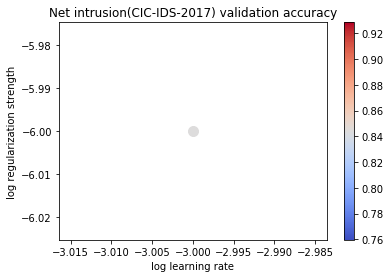

In [13]:
# Visualize the cross-validation results
import math
import matplotlib.pyplot as plt
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]


# plot validation accuracy
marker_size=100
colors = [results[x] for x in results] # default size of markers is 20

plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Net intrusion(CIC-IDS-2017) validation accuracy')
#plt.savefig('MachineLearningCVE/CNN_{}_layers_relu_{}th_run.png'.format(num_layers,run_number))
plt.show()